In [ ]:
import torch
import numpy as np
import pandas as pd
import torch.utils.data
import matplotlib.pyplot as plt
# ref: https://www.kaggle.com/code/t0m0ff3l/top-score-using-nearest-neighbours

In [261]:
train_data = pd.read_csv('./datasets/digit-recognizer/train.csv')
test_data = pd.read_csv('./datasets/digit-recognizer/test.csv')

In [262]:
X_train = train_data.loc[:,'pixel0':'pixel783'].values
y_train = train_data['label'].values

In [264]:
X_test = test_data.values
X_train.shape, y_train.shape, X_test.shape

((42000, 784), (42000,), (28000, 784))

*||X_i - Y_j||^2 = ||X_i||^2 + ||Y_j||^2 - 2<X_i, Y_j>*

- ||v||^2 is the squared Euclidean norm of vector v.
- <X_i, Y_j> is the dot product between X_i and Y_j

we can use **pairwise_distances** to calculate the distances between the given point and all other points, and then select the nearest neighbors based on these distances.

In [265]:
# view: reshapes the tensor without copying memory, similar to numpy's reshape.
# mm: matmal  
# clamp: set bouding box make sure that's not negative distance : 
# torch.clamp(torch.tensor([-10,2000]), 0 , 5000) -> tensor([   0, 2000])
def pairwise_distances(x, y):
    x_norm = (x**2).sum(1).view(-1, 1)
    y_norm = (y**2).sum(1).view(1, -1)
    y_t = torch.transpose(y, 0, 1)
    
    dist = x_norm + y_norm - 2.0 * torch.mm(x, y_t)
    return torch.clamp(dist, 0.0, np.inf)

pin_memory : When we **transfer data** from CPU memory to GPU memory, the data is first copied from the CPU to a pinned memory location, and then from there to GPU memory. Pinned memory has several advantages over regular memory, including faster data transfer rates and reduced CPU overhead.

In [266]:
%%time
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()

BATCH_SIZE = 128
dataset = torch.utils.data.TensorDataset(X_test) # compare what's the most nearest or looklike X_train
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, pin_memory=False)
_min_dists = []
_arg_min_dists = []

# min: return -> minimum values and argmin 
# axis=0 : along/each column
for batch, in dataloader : # , = x[0]
    min_distance, arg_min_distance = pairwise_distances(X_train, batch).min(axis=0)
    _min_dists.append(min_distance)
    _arg_min_dists.append(arg_min_distance)

CPU times: total: 1min 57s
Wall time: 30 s


In [267]:
min_dists = torch.cat(_min_dists, axis=0)
arg_min_dists = torch.cat(_arg_min_dists, axis=0)

In [268]:
min_dists.shape, arg_min_dists.shape

(torch.Size([28000]), torch.Size([28000]))

In [302]:
# find the most looklike in X_train then see what that X_train label is.
print(f'this X_test: look like index {arg_min_dists[0]} of X_train the most -> X_train label is {y_train[arg_min_dists[0]]}')

this X_test: look like index 7872 of X_train the most -> X_train label is 2


In [293]:
sub = pd.read_csv('./datasets/digit-recognizer/sample_submission.csv')
sub.Label = y_train[arg_min_dists] # what is X_test loolike X_train index the most  
sub.to_csv('./datasets/digit-recognizer/submission.csv', index=False)

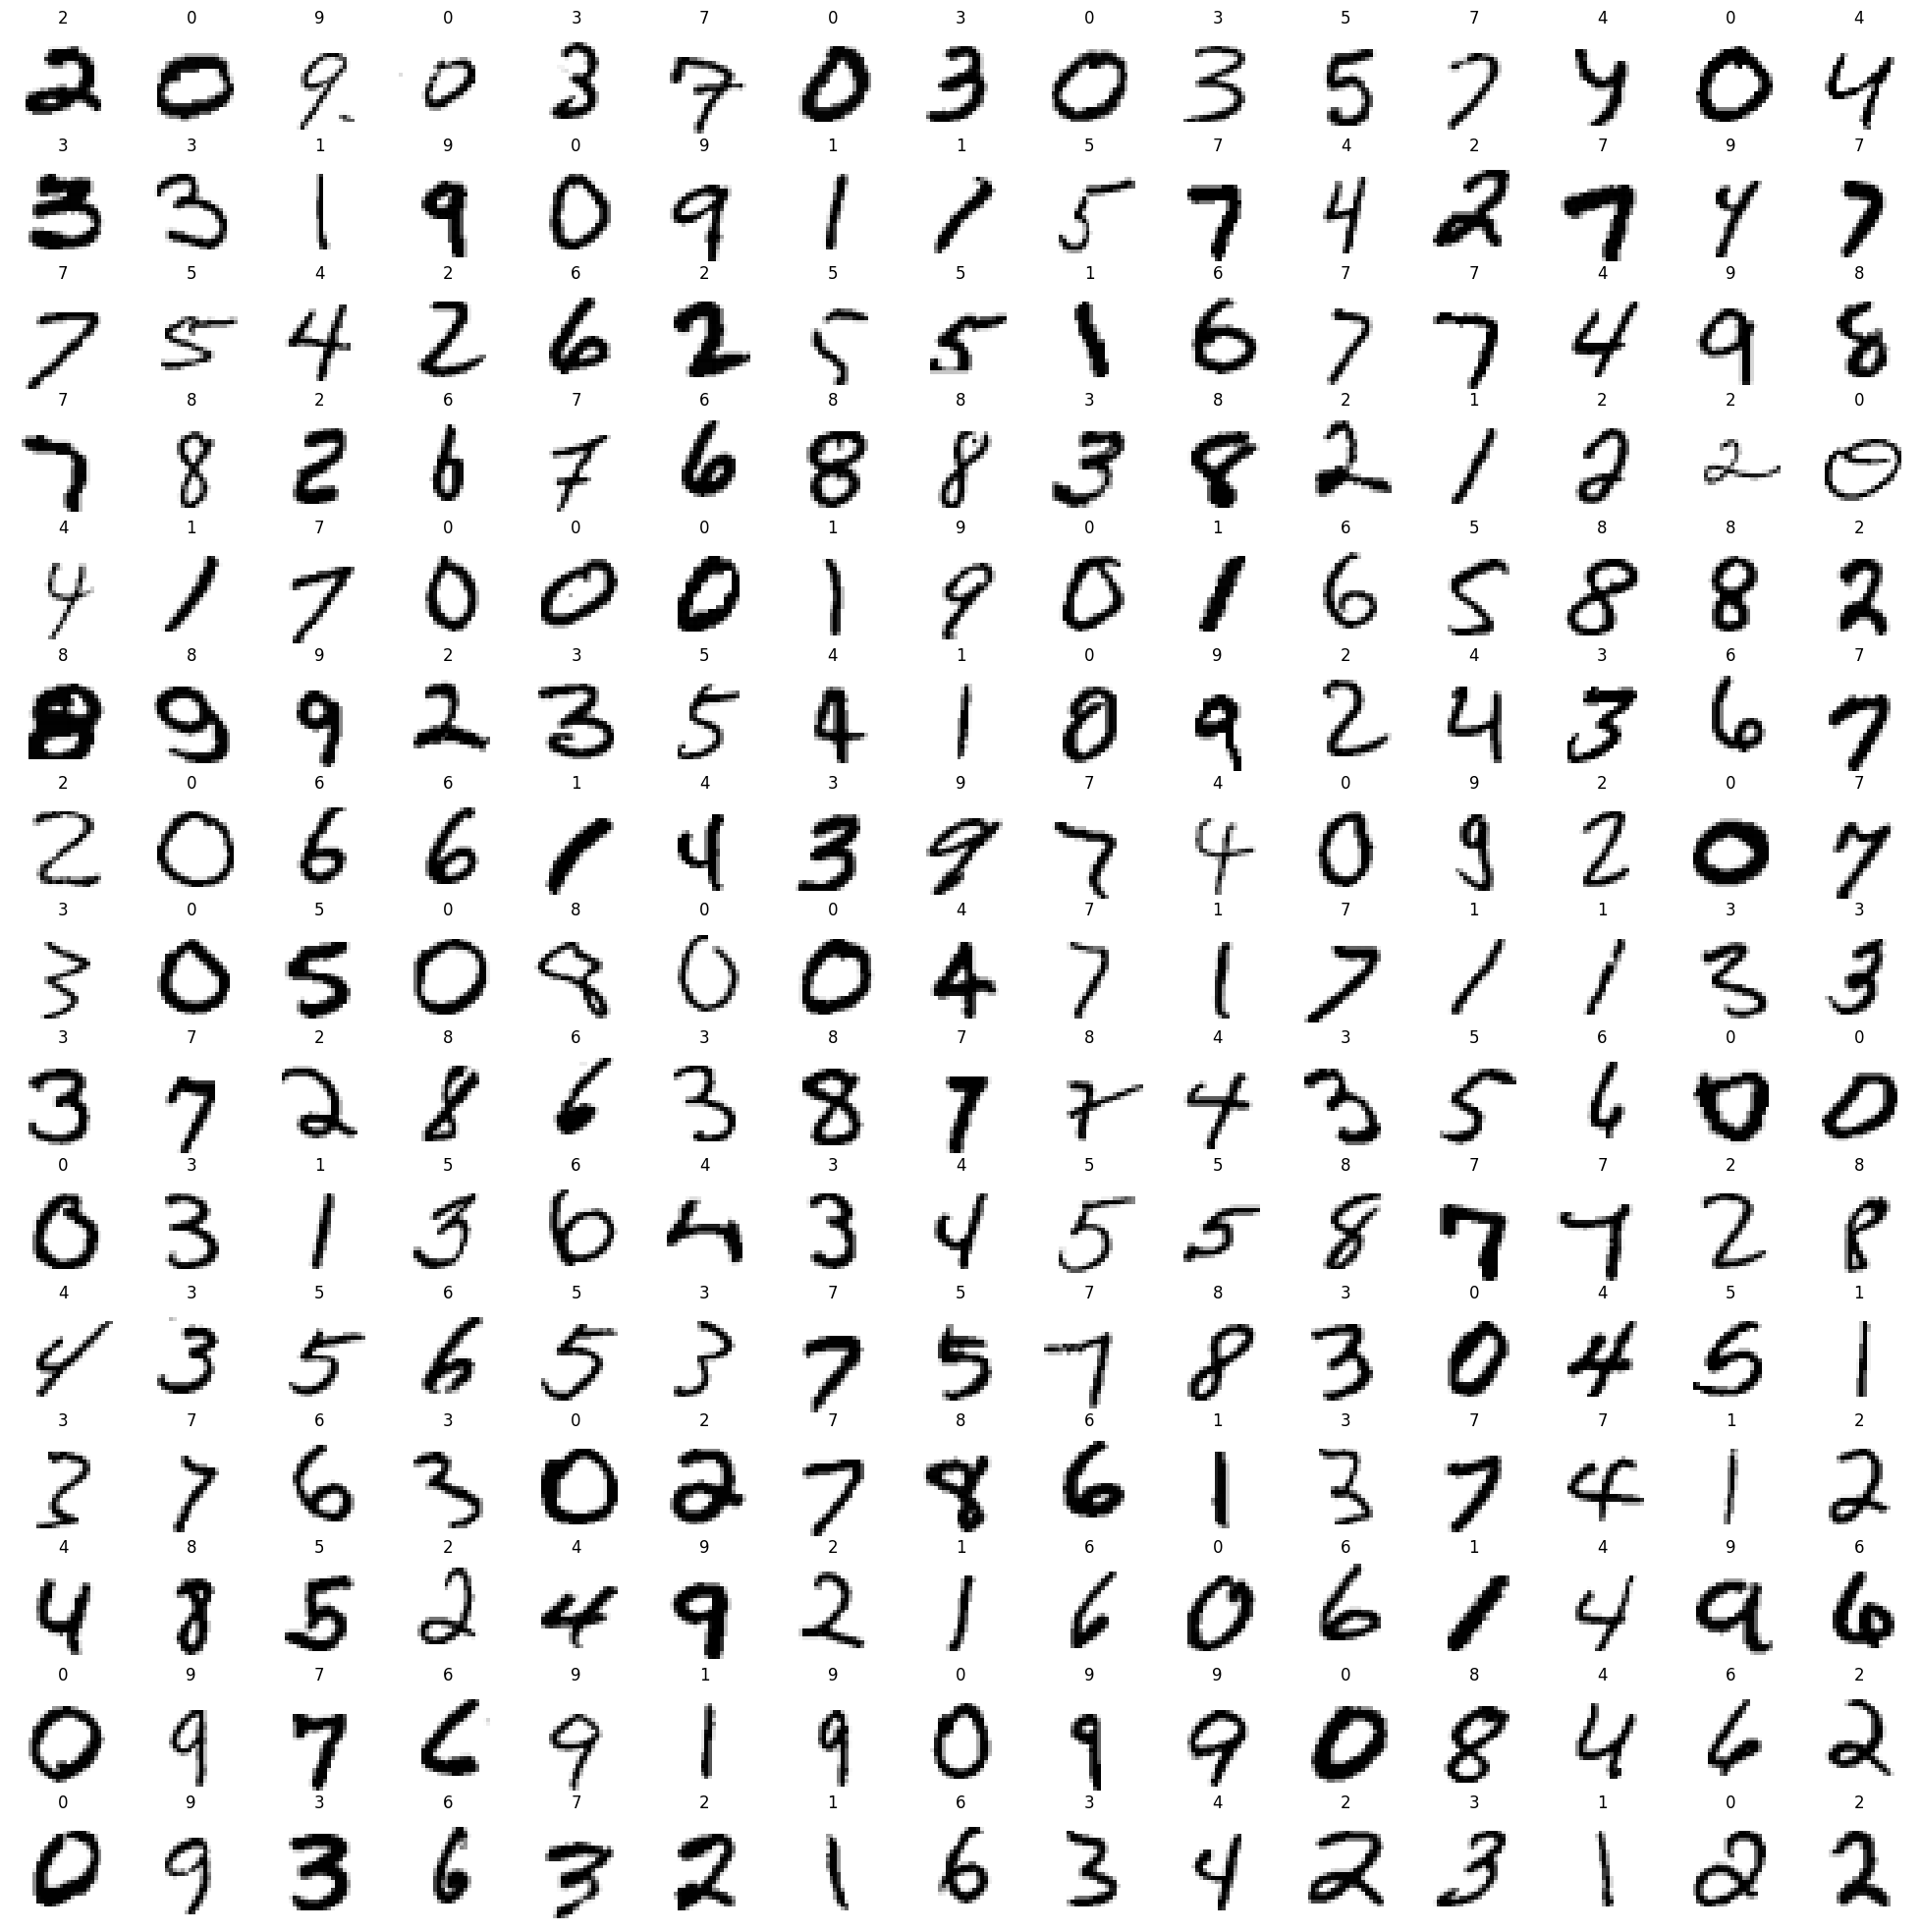

In [298]:
fig, axs = plt.subplots(15, 15, figsize=(25,25))
for i, ax in enumerate(axs.flatten()):
    ax.set_title(sub.Label[i])
    ax.imshow(X_test[i].reshape(28,28), cmap='binary')
    ax.axis('off')